In [1]:
from sys import platform
from struct import unpack
from hashlib import md5
import matplotlib.pyplot as plt
import cmath
import math
import pandas as pd
import numpy as np

from data import* 

['city', 'country', 'frpm', 'satscores', 'awards_players', 'coaches', 'draft', 'players', 'players_teams', 'series_post', 'teams', 'teams_post', 'game', 'opening']


#### Universe-Bernoulli Sampling (UBS)

In [2]:

def UBS(p: float, q: float, T: pd.DataFrame, J: str) -> pd.DataFrame:
    """
    [summary]
        Universe-Bernoulli Sampling
        (http://www.vldb.org/pvldb/vol13/p547-huang.pdf section 3.2 def 6)

    [Return]
        pd.DataFrame sampled from the given table

    [Parameters]
        p - (float): 0 < p ≤ 1 universe sampling rate
        q - (float): 0 < q ≤ 1 Bernoulli (uniform) sampling rate
        T - (pd.DataFrame): table
        J - (str): column name
    """
    def universal_hash(s: str):
        n = 4 if platform == 'win32' else 8
        return float(unpack('L', md5(s.encode('utf8')).digest()[:n])[0]) / 2**32

    feature = T[J].dropna().astype('str')
    prob = (feature.apply(universal_hash))
    universe_sample = [i for i, pr in enumerate(prob) if pr < p]

    T = T.loc[universe_sample]

    sample = T.sample(frac=q)
    return sample


### 5.1 Join Size Estimation: Count on Joins
#### Estimator for Ecount 


In [3]:
def join_count_estimate(parameters, sam_join_size):
    p = parameters[0]
    q1 = parameters[1]
    q2 = parameters[2]
    print("est",sam_join_size, p,q1,q2 )
    i_count_estimate = (1/(p*q1*q2))*sam_join_size
    return i_count_estimate

#### Theorem 11. Optimal sampling parameters

In [4]:

def get_gamma(A, B, i,j):
    c = 0
    for a,va in A.items():
        for b,vb in B.items():
            if a == b:
                c +=  (float(va)**i) * (float(vb)**j)
    return c

def get_gamma_v2(A, B, i,j):
    c = 0
    if(i == 1):
        freq_list_1 = A
    else:
        freq_list_1 = B
    if(j == 1):
        freq_list_2 = A
    else:
        freq_list_2 = B
        
    for a,va in freq_list_1.items():
        for b,vb in freq_list_2.items():
            if a == b:
                c +=  float(va) * float(vb)
    return c
    
def get_gamma_set(A,B):
    g11 = get_gamma(A,B,1,1)
    g12 = get_gamma(A,B,1,2)
    g21 = get_gamma(A,B,2,1)
    g22 = get_gamma(A,B,2,2)
    return (g11,g12,g21,g22)

def get_gamma_set_v2(A,B):
    g11 = get_gamma_v2(A,B,1,1)
    g12 = get_gamma_v2(A,B,1,2)
    g21 = get_gamma_v2(A,B,2,1)
    g22 = get_gamma_v2(A,B,2,2)
    return (g11,g12,g21,g22)

def optimal_universe_sampling_rate(esr1,esr2, gammas):
    g11 = gammas[0]
    g12 = gammas[1]
    g21 = gammas[2]
    g22 = gammas[3]
    
    print("check: " +(esr1*esr2*g22-g12-g21+g11)/g11)
    opt_para = cmath.sqrt((esr1*esr2*g22-g12-g21+g11)/g11)
#     print(type(opt_para))

    if isinstance(opt_para, complex):
        opt_para = 0
    return min(1, max(esr1,esr2,opt_para))

def optimal_sampling_parameters(esr1,esr2, gammas):
    p = optimal_universe_sampling_rate(esr1,esr2, gammas)
    q1 = esr1/p
    q2 = esr2/p
    return (p,q1,q2,esr1,esr2)

# # gamma_set = get_gamma_set(city_freq, country_freq)
# gamma_set = get_gamma_set_v2(city_freq, country_freq)

# parameters = optimal_sampling_parameters(0.9,0.9, gamma_set)

# print(f"gammas: g11, g12, g21, g22 {gamma_set}")
# print(f"parameters: p, q1, q2, esr1, esr2: {parameters}")


#### Lemma 8

In [5]:
def get_variance(parameters, gammas):
    p = parameters[0]
    q1 = parameters[1]
    q2 = parameters[2]
    esr1 = parameters[3]
    esr2 = parameters[4]
    
    g11 = gammas[0]
    g12 = gammas[1]
    g21 = gammas[2]
    g22 = gammas[3]

    var_j_count = ((1-p)/p)*g22 + ((1-q2)/(p*q2))*g21 + ((1 - q1)/(p*q1))*g12 \
    + (((1 - q1)*(1 - q2))/(p*q1*q2))*g11
    
    return var_j_count

#### 5.1.1 Centralized Sampling for Count

In [6]:
def get_variance_c(parameters, gammas):
    p = parameters[0]
    q1 = parameters[1]
    q2 = parameters[2]
    esr1 = parameters[3]
    esr2 = parameters[4]
    
    g11 = gammas[0]
    g12 = gammas[1]
    g21 = gammas[2]
    g22 = gammas[3]
    

    var_j_count = ((1/p)-1)*g22 + ((1/esr2)-(1/p))*g21 + ((1/esr1) - (1/p))*g12 \
    + ((p/(esr1*esr2)) - (1/esr1) - (1/esr2) + (1/p))*g11
    return var_j_count
    

#### 5.1.2 Decentralized Sampling for Count

In [7]:
def get_variance_d(parameters, gammas):
    p = parameters[0]
    q1 = parameters[1]
    q2 = parameters[2]
    esr1 = parameters[3]
    esr2 = parameters[4]
    
    g11 = gammas[0]
    g12 = gammas[1]
    g21 = gammas[2]
    g22 = gammas[3]
    
    var_j_count = ((1/p)-1)*g22 + ((1/esr2) - (1/p))*g21 + ((1/esr1) - (1/p))*g12 \
    + ((p/(esr1*esr2)) - (1/esr1) - (1/esr2) + (1/p))*g11
    return var_j_count
    

In [8]:
def get_variance_e(parameter, A ,B):
    join_size = 0
    for a,va in A.items():
        for b,vb in B.items():
            if a == b:
                join_size +=  float(va)*float(vb)
#     print(join_size)
    variance = ((1/parameter) - 1)* join_size
    return variance

### Estimate Join on World DB

#### Get tables frequencies

In [9]:
city_freq = dict(city['CountryCode'].value_counts())
country_freq = dict(country['Code'].value_counts())

#not 100 perecent correct
def get_freq_in_percent(target_list):
    freq_percent_list = {}
    length = 0
    
    for code, freq in target_list.items():
        length += freq
        
    for code, freq in target_list.items():
        freq_percent_list[code] = freq/length
    return freq_percent_list

city_freq_percent = get_freq_in_percent(city_freq)
country_freq_percent = get_freq_in_percent(country_freq)

#### Get optimal sampling parameters and variance freq

In [10]:

gamma_set = get_gamma_set(country_freq,city_freq )
gamma_set_test = get_gamma_set(city_freq,country_freq)
# gamma_set = get_gamma_set_v2(city_freq, country_freq)

parameters = optimal_sampling_parameters(0.9,0.9, gamma_set)

print(f"gammas: g11, g12, g21, g22 {gamma_set}")
print(f"gammas test : g11, g12, g21, g22 {gamma_set_test}")
print(f"parameters: p, q1, q2, esr1, esr2: {parameters}")
print(get_variance(parameters, gamma_set))
print(get_variance_c(parameters, gamma_set))
print(get_variance_d(parameters, gamma_set))
print(get_variance_e(0.9, city_freq,country_freq))


TypeError: can only concatenate str (not "float") to str

#### Variance graph

In [ ]:
# variance_range = []
# for increment_i in range (1,1000,1):
#     for increment_j in range (1,1000,1):
#         i = float(increment_i)/1000
#         j = float(increment_j)/1000
    
#         para = optimal_sampling_parameters(i,j, gamma_set)
#         variance_range.append(get_variance(para, gamma_set))
        
# variance_range.sort(reverse = True)  

In [11]:
variance_range = []
for increment_i in range (1,1000,1):
    i = float(increment_i)/1000
    variance_range.append(get_variance_e(i,city_freq, country_freq))
        
variance_range.sort(reverse = True)  
# print(variance_range)

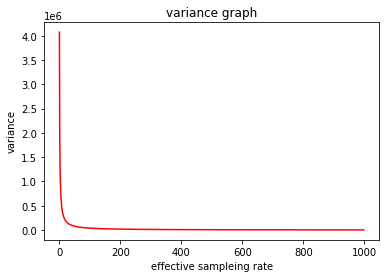

In [12]:
plt.title("variance graph")
plt.xlabel("effective sampleing rate")
plt.ylabel("variance")
plt.plot(variance_range, color ="red")
plt.show()

#### Get Join Count and Estimate Join Count

In [13]:

join_df = pd.merge(city,country, left_on='CountryCode', right_on='Code' )
print("Join counts: ", join_df.shape[0])

city_sample = UBS(0.9, 1, city, 'CountryCode')
country_sample = UBS(0.9, 1, country, 'Code')

sample_join_df =  pd.merge(city_sample,country_sample, left_on='CountryCode', right_on='Code' )

print("Sampling join count: ", sample_join_df.shape[0])
estimate_join_count = join_count_estimate(parameters , sample_join_df.shape[0])
print("Estimate join count: ", estimate_join_count)


Join counts:  4079
Sampling join count:  3769


NameError: name 'parameters' is not defined

In [ ]:
def join_count_estimate_2(p, q1, q2, sam_join_size):    
    i_count_estimate = (1/(p*q1*q2))*sam_join_size
    return i_count_estimate

def sampling_stats():
    estimate_jcounts = []
    for increment_i in range (1,100,1):
        city_sample = UBS(0.9, 1.0, city, 'CountryCode')
        country_sample = UBS(0.9, 1.0, country, 'Code')
        sample_j_count =  pd.merge(city_sample,country_sample, left_on='CountryCode', right_on='Code' ).shape[0]
        estimate_jcounts.append(join_count_estimate_2(0.9,1.0,1.0,sample_join_df.shape[0]))
    return estimate_jcounts

est_joins = sampling_stats()


In [ ]:
manual_vairance = sum([(ej- 4079 )*2 for ej in est_joins])/(len(est_joins) -1)
print(manual_vairance)

In [ ]:
# plt.title("sampling join estimate graph")
# plt.xlabel("effective sampleing rate")
# plt.ylabel("variance")
# plt.plot(est_joins, color ="red")
# plt.show()